In [2]:
from a01_clean_data import clean_data
from b02_fetch_weather import fetch_weather, clean_weather_data
import pandas as pd
import matplotlib as mpl

dfgym, mindate, maxdate = clean_data('../data/raw/data.csv')
dfweather = fetch_weather(mindate, maxdate)
dfweather = clean_weather_data(dfweather)
dfweather.to_csv("clean_weather_data.csv") # Export as a csv

In [3]:
# Merge the dataframes
df = pd.merge(dfgym, dfweather, on=["exact_date","hour"], how="left")

In [4]:
# Reorder columns
df = df[["exact_date","year","month","day","hour","minute","number_people","day_of_week","is_weekend","is_holiday","is_start_of_semester","is_during_semester","temp_f","rain_mm","weather_type"]]
df

,exact_date,year,month,day,hour,minute,number_people,day_of_week,is_weekend,is_holiday,is_start_of_semester,is_during_semester,temp_f,rain_mm,weather_type
0,2015-08-14,2015,8,15,17,0,37,Saturday,True,False,False,False,80.657600,0.0,Clear sky
1,2015-08-14,2015,8,15,17,20,45,Saturday,True,False,False,False,80.657600,0.0,Clear sky
2,2015-08-14,2015,8,15,17,30,40,Saturday,True,False,False,False,80.657600,0.0,Clear sky
3,2015-08-14,2015,8,15,17,40,44,Saturday,True,False,False,False,80.657600,0.0,Clear sky
4,2015-08-14,2015,8,15,17,50,45,Saturday,True,False,False,False,80.657600,0.0,Clear sky
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62192,2017-03-18,2017,3,19,18,40,23,Sunday,True,False,False,True,59.360001,0.0,Overcast
62193,2017-03-18,2017,3,19,18,50,21,Sunday,True,False,False,True,59.360001,0.0,Overcast
62194,2017-03-18,2017,3,19,19,0,25,Sunday,True,False,False,True,56.209999,0.0,Overcast
62195,2017-03-18,2017,3,19,19,10,18,Sunday,True,False,False,True,56.209999,0.0,Overcast


In [8]:
# Export as a csv for further use
df.to_csv("clean_gym_data.csv")

### Analysis

In [5]:
# 1. Calculate the "Rain Penalty"
# We compare the average people on clear days vs. rainy days
avg_people_clear = df[df['rain_mm'] == 0]['number_people'].mean()
avg_people_rain = df[df['rain_mm'] > 0]['number_people'].mean()

# This is our modifier (e.g., -5.2 people)
rain_impact = avg_people_rain - avg_people_clear

print(f"--- Weather Impact Analysis ---")
print(f"Average crowd (Clear): {avg_people_clear:.1f}")
print(f"Average crowd (Rainy): {avg_people_rain:.1f}")
print(f"Rain Impact Factor: {rain_impact:+.1f} people")

--- Weather Impact Analysis ---
Average crowd (Clear): 29.2
Average crowd (Rainy): 27.1
Rain Impact Factor: -2.1 people


--- Rain Penalty by Day of Week ---
  day_of_week  rain_penalty
1      Monday     -1.426766
5     Tuesday    -10.404751
6   Wednesday     -9.714240
4    Thursday     -1.306052
0      Friday      2.245589
2    Saturday      2.287369
3      Sunday      1.922638
-2.342316305486445


C:\Users\alexa\AppData\Local\Temp\ipykernel_26308\2825399947.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rain_impact_by_day = df.groupby('day_of_week').apply(calculate_rain_impact).reset_index(name='rain_penalty')
C:\Users\alexa\AppData\Local\Temp\ipykernel_26308\2825399947.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rain_impact_by_day, x='day_of_week', y='rain_penalty', palette=colors)


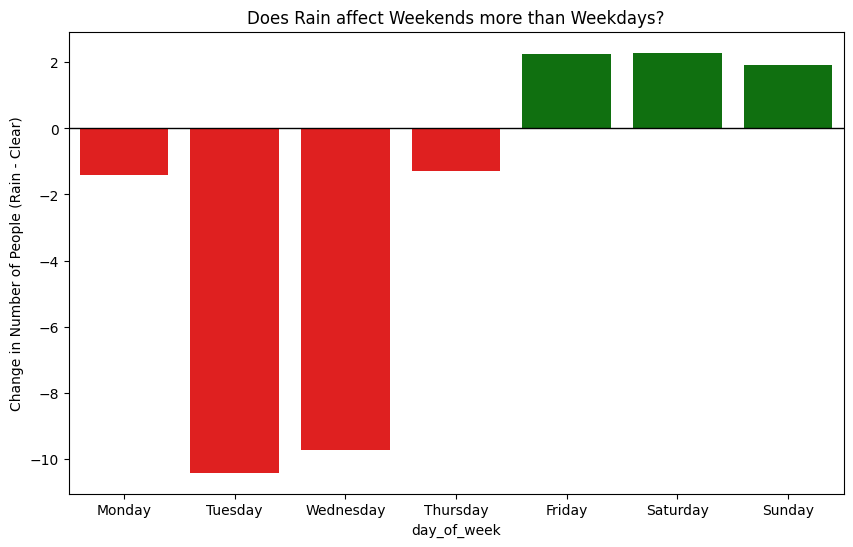

In [8]:
# 1. Create a custom function to calculate the penalty per group
def calculate_rain_impact(group):
    avg_rain = group[group['rain_mm'] > 0]['number_people'].mean()
    avg_clear = group[group['rain_mm'] == 0]['number_people'].mean()
    
    # Return the difference (Rain - Clear)
    # If there's no rain data for that day, return 0
    if pd.isna(avg_rain) or pd.isna(avg_clear):
        return 0
    return avg_rain - avg_clear

# 2. Group by Day of Week and apply the function
# We use a custom aggregation
rain_impact_by_day = df.groupby('day_of_week').apply(calculate_rain_impact).reset_index(name='rain_penalty')

# 3. Sort logically (Mon -> Sun) for easier reading
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rain_impact_by_day['day_of_week'] = pd.Categorical(rain_impact_by_day['day_of_week'], categories=days_order, ordered=True)
rain_impact_by_day = rain_impact_by_day.sort_values('day_of_week')

print("--- Rain Penalty by Day of Week ---")
print(rain_impact_by_day)
print(rain_impact_by_day['rain_penalty'].mean())

# 4. Visualize it (Bar Chart)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# We color bars red if the penalty is negative (traffic drops), green if positive
colors = ['red' if x < 0 else 'green' for x in rain_impact_by_day['rain_penalty']]

sns.barplot(data=rain_impact_by_day, x='day_of_week', y='rain_penalty', palette=colors)
plt.axhline(0, color='black', linewidth=1) # Add a zero line
plt.title("Does Rain affect Weekends more than Weekdays?")
plt.ylabel("Change in Number of People (Rain - Clear)")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# 1. Prepare Features
# We need to convert text (Monday) into numbers for the model
# One-Hot Encoding for 'day_of_week'
model_df = pd.get_dummies(df, columns=['day_of_week'], drop_first=True)

# Select features
features = [
    'hour', 'temp_f', 'rain_mm', 'is_weekend', 
    'is_start_of_semester', 'is_during_semester'
] + [col for col in model_df.columns if 'day_of_week_' in col]

X = model_df[features]
y = model_df['number_people']

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train Model
print("Training Random Forest Model... (This might take a minute)")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all cores
rf_model.fit(X_train, y_train)

# 4. Evaluate
predictions = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Model Performance:")
print(f"Mean Absolute Error: {mae:.2f} people (On average, we are off by this many people)")
print(f"R² Score: {r2:.2f} (We explain {r2*100:.1f}% of the variance)")

# 5. Feature Importance (The "Why")
import pandas as pd
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(importance.head(5))

Training Random Forest Model... (This might take a minute)
Model Performance:
Mean Absolute Error: 4.55 people (On average, we are off by this many people)
R² Score: 0.91 (We explain 90.8% of the variance)


,Feature,Importance
0,hour,0.526744
1,temp_f,0.232305
5,is_during_semester,0.112361
3,is_weekend,0.035486
4,is_start_of_semester,0.019035
